In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# README

## Usage

`output_qd.csv` and `output_rtt.csv` (as generated by the client program) should
be placed inside `DATA_DIR` as defined below - this directory can be modified
(in the case that you have several outputs backed up in different directories)

## Data layout

The data is stored as `.csv`, with each file representing a vector of 
histograms - that is, one histogram for every `(throughput, srv)` pair. The rows
are 

- `nanos`: the first nanosecond value in a histogram bucket
- `count`: the number of counted data points in a bucket
- `throughput`: the throughput in Rps of a data point
- `srv`: one tenth of the configured service time for the data point

In [2]:
DATA_DIR = '.'

In [3]:
df_qd  = pd.read_csv(DATA_DIR+'/output_qd.csv').sort_values(by="nanos")
df_rtt = pd.read_csv(DATA_DIR+'/output_rtt.csv').sort_values(by="nanos")

In [4]:
# queuing delay dataframe
df_qd

,nanos,count,throughput,srv_time
24,0,447,10000,1
365,0,9638,320000,1
40,0,55,10000,10
57,0,1191,20000,1
319,0,485,160000,10
...,...,...,...,...
153,6208000,1,40000,1
179,6358000,1,40000,1
138,6555000,1,40000,1
123,6701000,1,40000,1


In [5]:
# round trip time dataframe
df_rtt

,nanos,count,throughput,srv_time
3599,4000,3,20000,1
1810,4000,2,10000,1
6507,5000,3,20000,10
814,5000,7,10000,1
4353,5000,20,20000,1
...,...,...,...,...
26991,30592000,1,160000,1
24622,30595000,1,160000,1
24628,30790000,1,160000,1
24627,30793000,1,160000,1


In [7]:
def find_percentile_index(df: pd.DataFrame, percentile: float) -> int:
    """
    finds the row index of the 99th percentile `nanos` value of a dataframe
    """
    total_packets = df[f'count'].sum()
    target_count = total_packets * (percentile / 100)
    return np.argmax(df[f'cum_count'] >= target_count)

In [8]:
grouped_qds = df_qd.groupby(['throughput', 'srv_time'])
grouped_rtts = df_rtt.groupby(['throughput', 'srv_time'])

p99_qds = {}
for (throughput, service_time), sub_df in grouped_qds:
    sub_df['cum_count'] = sub_df['count'].cumsum()
    idx = find_percentile_index(sub_df, 99)
    p99_qd = sub_df.iloc[idx]["nanos"] / 1000.0

    p99_qds[service_time] = p99_qds.get(service_time, {})
    p99_qds[service_time][throughput] = p99_qd

p99_rtts = {}
for (throughput, rtt), sub_df in grouped_rtts:
    sub_df['cum_count'] = sub_df['count'].cumsum()
    idx = find_percentile_index(sub_df, 99)
    p99_rtt = sub_df.iloc[idx]["nanos"] / 1000.0

    p99_rtts[rtt] = p99_rtts.get(rtt, {})
    p99_rtts[rtt][throughput] = p99_rtt
print(p99_rtts)

{np.int64(1): {np.int64(10000): np.float64(17127.0), np.int64(20000): np.float64(3456.0), np.int64(40000): np.float64(5596.0), np.int64(80000): np.float64(5171.0), np.int64(160000): np.float64(7769.0), np.int64(320000): np.float64(6239.0)}, np.int64(10): {np.int64(10000): np.float64(16917.0), np.int64(20000): np.float64(3178.0), np.int64(40000): np.float64(5602.0), np.int64(80000): np.float64(4937.0), np.int64(160000): np.float64(8402.0), np.int64(320000): np.float64(6360.0)}}


In [9]:
srv_times = df_qd['srv_time'].unique()

# Generate 99th percentile queuing delay vs. throughput plots for all distinct service time values

/tmp/ipykernel_467858/3812669949.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


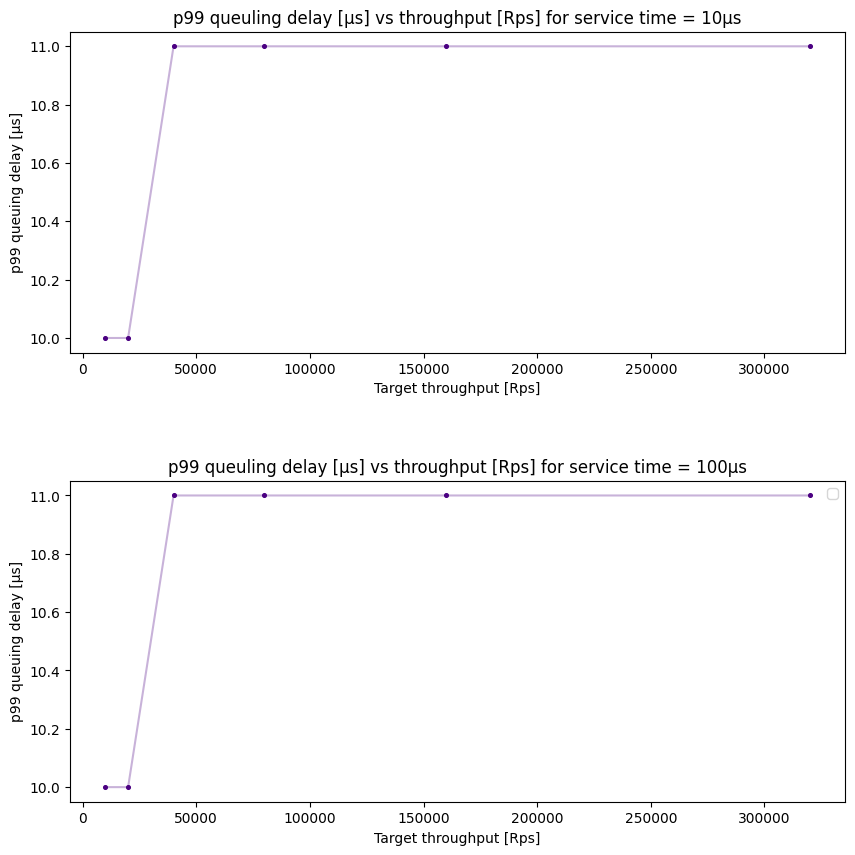

In [10]:
fig, axes = plt.subplots(len(srv_times), 1, figsize=(10, 5*len(srv_times)))

plt.title(f'p99 queuling delay [μs] vs throughput [Rps]')
plt.legend()
plt.subplots_adjust(hspace=0.4)

for i, srv in enumerate(srv_times):
    ax = axes[i] if len(srv_times) > 1 else axes

    plot_data = p99_qds[srv]

    ax.plot(plot_data.keys(), plot_data.values(), color='indigo', alpha=0.3)
    ax.scatter(plot_data.keys(), plot_data.values(), color='indigo', s=7)
    ax.set_title(f'p99 queuling delay [μs] vs throughput [Rps] for service time = {srv*10}μs')
    ax.set_ylabel("p99 queuing delay [μs]")
    ax.set_xlabel("Target throughput [Rps]")

/tmp/ipykernel_467858/4155490242.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


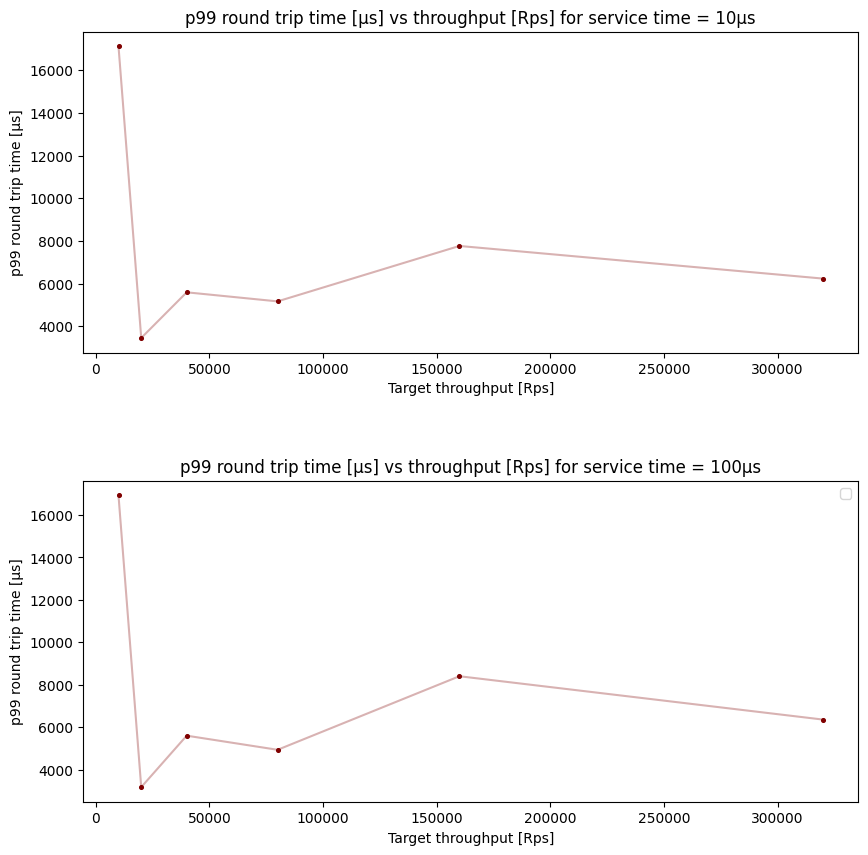

In [11]:
fig, axes = plt.subplots(len(srv_times), 1, figsize=(10, 5*len(srv_times)))

plt.title(f'p99 round trip times delay [μs] vs throughput [Rps]')
plt.legend()
plt.subplots_adjust(hspace=0.4)

for i, srv in enumerate(srv_times):
    ax = axes[i] if len(srv_times) > 1 else axes

    plot_data = p99_rtts[srv]

    ax.plot(plot_data.keys(), plot_data.values(), color='maroon', alpha=0.3)
    ax.scatter(plot_data.keys(), plot_data.values(), color='maroon', s=7)
    ax.set_title(f'p99 round trip time [μs] vs throughput [Rps] for service time = {srv*10}μs')
    ax.set_ylabel("p99 round trip time [μs]")
    ax.set_xlabel("Target throughput [Rps]")